In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
!pip install boto3 python-dotenv split-folders

import boto3
import json
import os
import pandas as pd
import seaborn as sn
import splitfolders
import tarfile

from dotenv import load_dotenv
from google.colab import drive
from matplotlib import pyplot as plt
from tensorflow import keras

%matplotlib inline

Mount drive for accessing the dataset

In [3]:
drive.mount('/content/drive')
DATA_PATH = '/content/drive/My Drive/animal-classifier'

Mounted at /content/drive


Constants

In [4]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
CHANNELS = 3

BATCH_SIZE = 128
EPOCHS = 200

Extract dataset from zip archive

In [5]:
dataset_path = 'datasets/'
animals10_path = f'{dataset_path}animals10'
if not os.path.isdir(animals10_path):
    with tarfile.open(f'{DATA_PATH}/animals10.tgz') as tar:
        tar.extractall(dataset_path)
sum((len(f) for _, _, f in os.walk(animals10_path)))

26179

Split training & validation data

In [6]:
process_path = 'data/animals10'
if not os.path.isdir(process_path):
    splitfolders.ratio(animals10_path, output=process_path, seed=1337, ratio=(0.75, 0.25))

Copying files: 26179 files [00:04, 5619.61 files/s]


Generator setup

In [7]:
train_gen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)
test_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [10]:
ds_args = lambda dir: {
    'directory': f'{process_path}/{dir}',
    'batch_size': BATCH_SIZE,
    'shuffle': dir == 'train',
    'target_size': (IMG_HEIGHT, IMG_WIDTH),
}
train_ds = train_gen.flow_from_directory(**ds_args('train'))
val_ds = test_gen.flow_from_directory(**ds_args('val'))

Found 19631 images belonging to 10 classes.
Found 6548 images belonging to 10 classes.


In [11]:
N_CLASSES = train_ds.num_classes
train_count, val_count = train_ds.n, val_ds.n
print(f'{train_ds.image_shape} {train_count} {val_count}')

(128, 128, 3) 19631 6548


Model setup

In [12]:
model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)),
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1)),
    keras.layers.ReLU(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1)),
    keras.layers.ReLU(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1)),
    keras.layers.ReLU(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1)),
    keras.layers.ReLU(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(units=512),
    keras.layers.ReLU(),
    keras.layers.Dropout(rate=0.4),
    keras.layers.Dense(units=512),
    keras.layers.ReLU(),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(units=256),
    keras.layers.ReLU(),
    keras.layers.Dense(N_CLASSES),
    keras.layers.Softmax(),
])
model.compile(
    optimizer=tf.optimizers.Adam(0.0002),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'],
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 64)      1792      
_________________________________________________________________
re_lu (ReLU)                 (None, 126, 126, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        36928     
_________________________________________________________________
re_lu_1 (ReLU)               (None, 61, 61, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       7

Callback setup

In [13]:
checkpoint_path = 'tmp/training.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

Train model

In [14]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    steps_per_epoch=train_count // BATCH_SIZE,
    validation_steps=val_count // BATCH_SIZE,
    verbose=1,
    callbacks=[
        checkpoint_callback,
    ],
)

153/153 [==============================] - 120s 784ms/step - loss: 2.1377 - accuracy: 0.2298 - val_loss: 1.9553 - val_accuracy: 0.3180


Save model

In [13]:
# checkpoint_callback.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [14]:
model_dir = 'models/animal'
model.save(model_dir)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/animal/assets


Convert model

In [15]:
converter = tf.lite.TFLiteConverter.from_saved_model(model_dir)
tflite_model = converter.convert()
tflite_model_file = f'{model_dir}.tflite'
with open(tflite_model_file, 'wb') as f:
    f.write(tflite_model)

S3 setup

In [16]:
basedir =  os.path.abspath(DATA_PATH)
load_dotenv(os.path.join(basedir, '.env'))

access_key = os.getenv('AWS_ACCESS_KEY')
secret_key = os.getenv('AWS_SECRET_KEY')
bucket = os.getenv('TEST_MODEL_BUCKET')

session = boto3.Session(
    aws_access_key_id=access_key,
    aws_secret_access_key=secret_key,
)

S3 upload

In [17]:
s3 = session.resource('s3')
s3.meta.client.upload_file(tflite_model_file, bucket, 'animal/animal.tflite')

output_translation = {v: k for k, v in train_ds.class_indices.items()}
output_translation_file = f'{model_dir}.json'
with open(output_translation_file, 'w') as f:
    json.dump(output_translation, f)
s3.meta.client.upload_file(output_translation_file, bucket, 'animal/animal.json')

Plots

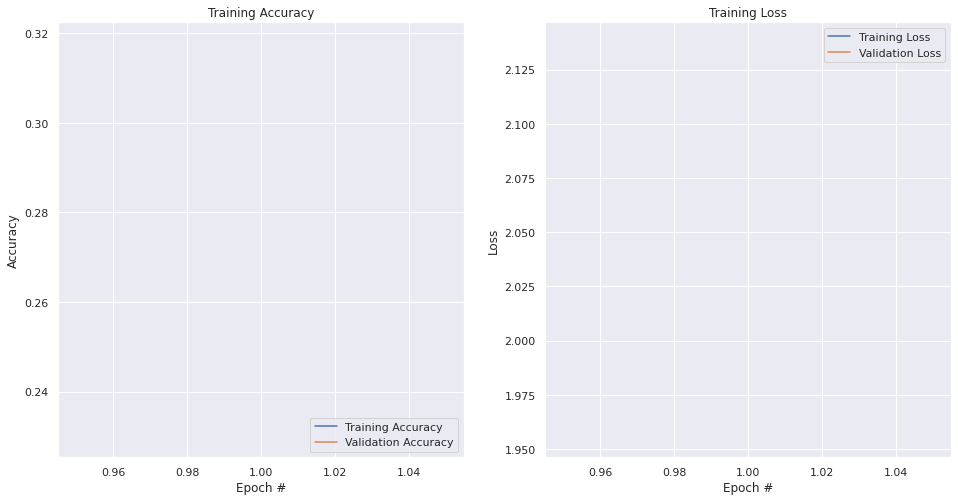

In [15]:
sn.set_theme()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1,len(acc)+1)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.savefig(os.path.join(DATA_PATH, 'metrics.png'))
plt.show()
plt.close()

In [17]:
test_preds = model.predict(val_ds)
predictions = tf.argmax(test_preds, axis=1)

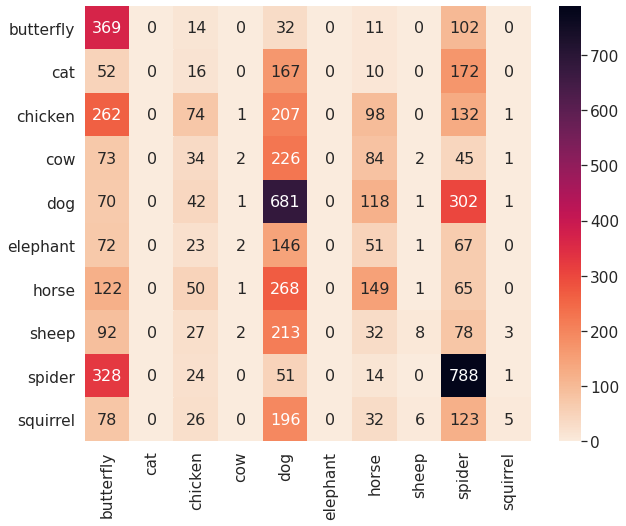

In [20]:
confusion_matrix = tf.math.confusion_matrix(val_ds.classes, predictions, num_classes=N_CLASSES)
labels = list(val_ds.class_indices.keys())
plt.figure(figsize=(10, 8))
sn.set(font_scale=1.4)
sn.heatmap(confusion_matrix, annot=True, annot_kws={'size': 16}, fmt='d', cmap=sn.cm.rocket_r, xticklabels=labels, yticklabels=labels)
plt.savefig(os.path.join(DATA_PATH, 'confusion_matrix.png'))
plt.show()
plt.close()